# Data preprocessing
This notebook contains code to clean and standartise datasets used for the analysis.

### Importing Libraries:

In [1]:
# data processing
import pandas as pd
import numpy as np
from datetime import datetime

# data visualisation
import seaborn as sns
import matplotlib.pyplot as plt
import folium

# get geographical data
from geopy.geocoders import ArcGIS

# to interact with operating system to save files
import os
from os.path import dirname

# custom function
from standardiseSubscriptions import rename_subs # will work in jupyter notebook 

# Ignoring warning
import logging
import requests
import warnings
warnings.filterwarnings("ignore")
logging.getLogger(requests.packages.urllib3.__package__).setLevel(logging.ERROR)

## Importing datasets:
1) stations_df: Containing all information on bike share stations  
2) trips_df: Containing all information on bike trips taken from December 2013 - March 2023  
3) weather_df: Containing all information on weather in Austin  

In [2]:
# Loading the datasets
stations_df = pd.read_csv("../Data/bikeshare_stations.csv")
trips_df = pd.read_csv("../Data/bikeshare_trips.csv", parse_dates=["start_time"], low_memory=False)

# List of CSV file names
files = ['../Data/Austin_TX_2014-01-01_to_2015-12-31.csv', 
         '../Data/Austin_TX_2016-01-01_to_2017-12-31.csv', 
         '../Data/Austin_TX_2018-01-01_to_2019-12-31.csv', 
         '../Data/Austin_TX_2020-01-01_to_2021-12-31.csv', 
         '../Data/Austin_TX_2022-01-01_to_2022-12-31.csv']

# Create a list to hold dataframes
dfs = []

# Read each CSV file and append it to the list
for file in files:
    dfs.append(pd.read_csv(file))

# Concatenate all dataframes into one
combined_df = pd.concat(dfs, ignore_index=True)

# Write the combined dataframe to a new CSV file on Windows
curr_dir = os.getcwd()
# parent_folder = dirname(curr_dir) 
# if os.path.exists(parent_folder + "\\Data"):
#     combined_df.to_csv(parent_folder + '\\Data\\combined_weather.csv', index=False)
# else:
#     os.mkdir(parent_folder + "\\Data")
#     combined_df.to_csv(parent_folder + "\\Data\\combined_weather.csv", index=False)
    
# Write the combined dataframe to a new CSV file on Mac/Linux
curr_dir = os.getcwd()
parent_folder = dirname(curr_dir) 
if os.path.exists(parent_folder + "/Data"):
    combined_df.to_csv(parent_folder + '/Data/combined_weather.csv', index=False)
else:
    os.mkdir(parent_folder + "/Data")
    combined_df.to_csv(parent_folder + "/Data/combined_weather.csv", index=False)

weather_df = pd.read_csv("../Data/combined_weather.csv")


# Cleaning Data
- Rename column names  
- Pre-processing of string data types  
- Find geographical coordinates of the bike stations  
- Handle missing/ null values  
- Process datetime columns
- Imputing Missing
- Check validity of station_id
- Exclude incomplete boundary years 
- Fulfill the incomplete years


### Rename column names

In [3]:
#Rename column name for dataset trip, set it to Title and inplace = True
trips_df = trips_df.rename(columns={'bikeid':'bike_id'}).rename(columns=str.lower)

#Rename column name for dataset trip, set it to Title and inplace = True
stations_df = stations_df.rename(columns={'name':'station_name'}).rename(columns=str.lower)

### Pre-processing of string data types:
- Removal of leading and trailing whitespaces
- Removal of punctuaton in address column
- Standardisation of address, for eg "St" vs "Street", "E" vs "East"
- Some entries are not actually addresses
- Standartising "subscriber_type" column values

In [4]:
# remove trailing and leading whitespaces
strip_spaces = lambda x: x.str.strip()
stations_df[['station_name', 'status','address','notes']] = stations_df[['station_name', 'status','address','notes']].apply(strip_spaces)

# remove punctuation in address column
stations_df['address'] = stations_df['address'].str.replace('.', '', regex=True)

# Fill null values in address column with bike station name
stations_df["address"] = stations_df["address"].fillna(stations_df["station_name"])

# Find rows where address is incorrect and replace with bike station name
stations_df.loc[stations_df['address'].str.contains('Presented'), 'address'] = stations_df['station_name']

# Standardise address, for eg. "Road" is replaced by "Rd" 

words_dict = {'Street' : 'St', 'Avenue' : 'Ave', 'Road':'Rd', 
              'Drive': 'Dr', 'Boulevard' : 'Blvd', 'North' : 'N', 
              'South' : 'S', 'East' : 'E', 'West': 'W'}

# get(key, value)
stations_df['address'] = stations_df['address'].apply(lambda x: ' '.join([words_dict.get(i, i) for i in x.split()]))

# Make sure the values in "subscriber_type" column are of string type
trips_df['subscriber_type'] = trips_df['subscriber_type'].astype(str)

# Standardise subscriptions
trips_df['subscriber_type'] = trips_df['subscriber_type'].apply(rename_subs) 

### Find geographical coordinates of the bike stations
Using ArcGIS, a web-based mapping software, we can input the given address of the bike stations from the dataset and get the full address, longtitude and latitude.  
With this information, we can create visuals to see location of bike stations and journeys taken by bike riders.  

We will create three new columns:
- full_adresss
- longitude
- latitude

Not all the addresses generated were accurate so these had to be changed manually.

In [5]:
#Add 'Austin Texas' to give more information
stations_df['address'] = stations_df['address'] + ' Austin Texas' 

# Initiate ArcGIS
nom = ArcGIS()

# Create column that gets address, latitude and longitude
stations_df['coordinates']=stations_df['address'].apply(nom.geocode)

#extract coordinates and store it in lat and lon columns
stations_df['full_address']=stations_df['coordinates'].apply(lambda x:x.address)
stations_df['lat']=stations_df['coordinates'].apply(lambda x:x.latitude)
stations_df['lon']=stations_df['coordinates'].apply(lambda x:x.longitude)

# Not all rows were successfully matched, find rows where location was not found to be Austin and change manually
# station_id 2546, 2566, 2537 are incorrect.

stations_df[~stations_df['full_address'].str.contains('Austin')] 

# Manually change data for station_id 2546, 2566, 2537 based on long and lat on Google Maps
stations_df.loc[stations_df['station_id'] == 2546, ['full_address', 'lat', 'lon']]  = ['1231 W Ave, Austin, Texas, 78701', 30.276460, -97.748220]

stations_df.loc[stations_df['station_id'] == 2566, ['full_address', 'lat', 'lon']]  = ['W 2nd St, Austin, Texas, 78701', 30.264320, -97.744490]

stations_df.loc[stations_df['station_id'] == 2537, ['full_address', 'lat', 'lon']]  = ['603 W Ave, Austin, Texas, 78701', 30.270678, -97.750389]

### Process datetime columns:
- Add day_of_week column  
- Add time column  
- Add month column  
- Add year column

In [6]:
# Add day_of_week column
trips_df["day_of_week"] = trips_df["start_time"].apply(lambda x: x.strftime('%A'))

# Add time column
trips_df["time"] = trips_df["start_time"].apply(lambda x: x.strftime('%H:%M:%S'))

# Add month column
trips_df["month"] = trips_df["start_time"].apply(lambda x: x.strftime('%b'))

# Add year column to trips_df   
trips_df["year"] = trips_df["start_time"].apply(lambda x: x.strftime('%Y'))

### Handling missing/ null values

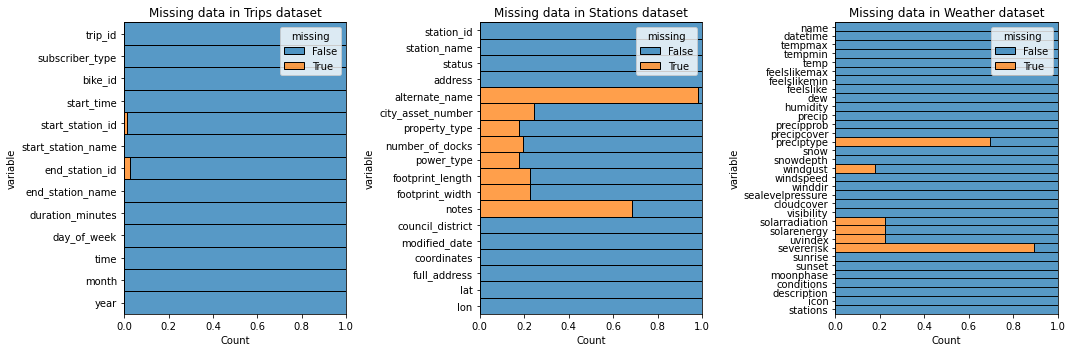

In [7]:
#Plots in a single line

# Create a single plot with three subplots placed horizontally
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Ploting the missing data in the trips dataset
sns.histplot(data=trips_df.isna().melt(value_name="missing"), y="variable", hue="missing", multiple="fill", ax=axes[0])
axes[0].set_title("Missing data in Trips dataset")

# Ploting the missing data in the stations dataset
sns.histplot(data=stations_df.isna().melt(value_name="missing"), y="variable", hue="missing", multiple="fill", ax=axes[1])
axes[1].set_title("Missing data in Stations dataset")

# Ploting the missing data in the weather dataset
sns.histplot(data=weather_df.isna().melt(value_name="missing"), y="variable", hue="missing", multiple="fill", ax=axes[2])
axes[2].set_title("Missing data in Weather dataset")

# Save the figure on Windows
# if os.path.exists(parent_folder + "\\Figures"):
#     plt.savefig(parent_folder + "\\Figures\\Missing_data_in_datasets.png")
# else:
#     os.mkdir(parent_folder + "\Figures")
#     plt.savefig(parent_folder + "\\Figures\\Missing_data_in_datasets.png")

# Save the figure on Mac/Linux
curr_dir = os.getcwd()
parent_folder = dirname(curr_dir) 
if os.path.exists(parent_folder + "/Figures"):
    plt.savefig(parent_folder + "/Figures/Missing_data_in_datasets.png")
else:
    os.mkdir(parent_folder + "/Figures")
    plt.savefig(parent_folder + "/Figures/Missing_data_in_datasets.png")

plt.tight_layout()
plt.show()

In [8]:
# Loop through each column and drop it if there are more than 30% null values,
# or fill in the null values with the column mean if there are less than 50%
null_percent = stations_df.isnull().sum() / len(stations_df) * 100
for col in stations_df.columns:
    if null_percent[col] > 30:
        stations_df.drop(col, axis=1, inplace=True)
    elif null_percent[col] > 0:
        stations_df[col] = stations_df[col].fillna('0')


# Loop through each column and drop it if there are more than 30% null values,
# or fill in the null values with the column mean if there are less than 50%
null_percent = weather_df.isnull().sum() / len(weather_df) * 100
for col in weather_df.columns:
    if null_percent[col] > 30:
        weather_df.drop(col, axis=1, inplace=True)
    elif null_percent[col] > 0:
        weather_df[col] = weather_df[col].fillna('0')

### Impute missing data in trips_df

Trips data is missing for April 2016, December 2016 and November 2022.    

 
The missing values for April 2016 will be replaced by the data from the previous year, i.e April 2015.  
The missing values for December 2016 will be replaced by the data from the previous year, i.e December 2015. 
The missing values for November 2022 will be filled in by the most frequent end_staton_id for 2019, 2020, 2021.  


### Fill in missing values for November 2022

In [9]:
# Find the most frequent end_station_id in November 2021
november2021 = trips_df[(trips_df['year']=='2021') & (trips_df['month']=='Nov')]
pop_endstation_2021 = pd.DataFrame(november2021.groupby("end_station_id").size().sort_values(ascending=False)).reset_index().rename(columns={0: "frequency"})
print(f"The most frequent end_station_id in November 2021 is {pop_endstation_2021.iloc[0,0]}")

# Find the most frequent end_station_id in November 2020
november2020 = trips_df[(trips_df['year']=='2020') & (trips_df['month']=='Nov')]
pop_endstation_2020 = pd.DataFrame(november2020.groupby("end_station_id").size().sort_values(ascending=False)).reset_index().rename(columns={0: "frequency"})
print(f"The most frequent end_station_id in November 2020 is {pop_endstation_2020.iloc[0,0]}")

# Find the most frequent end_station_id in November 2019
november2019 = trips_df[(trips_df['year']=='2019') & (trips_df['month']=='Nov')]
pop_endstation_2019 = pd.DataFrame(november2019.groupby("end_station_id").size().sort_values(ascending=False)).reset_index().rename(columns={0: "frequency"})
print(f"The most frequent end_station_id in November 2019 is {pop_endstation_2019.iloc[0,0]}")

# Get existing data for November 2022
november2022_df = trips_df[(trips_df['year']=='2022') & (trips_df['month']=='Nov')]

# Fill missing values in the end_station_id column for November 2022 and consequently change the end_station_name to the corresponding to the end_station_id
november2022_df.fillna(3798, inplace=True)
november2022_df.iloc[:, 7]="21st & Speedway @PCL"

The most frequent end_station_id in November 2021 is 3798
The most frequent end_station_id in November 2020 is 3798
The most frequent end_station_id in November 2019 is 3798


### Fill in missing values for December 2016

In [10]:
# Get data for December 2015 to copy this data to December 2016
december2015 = trips_df[(trips_df['year']=='2015') & (trips_df['month']=='Dec')]

# Get synthetic values for December 2016
dec2016_index=np.arange(0,10029)
dec16_trip_ids = np.arange(30000000,30010029)
dec16_subscriber_type = pd.Series(december2015['subscriber_type']).reset_index().drop(columns="index")
dec16_subscriber_type = dec16_subscriber_type['subscriber_type']
dec16_bike_id = pd.Series(december2015['bike_id']).reset_index().drop(columns="index")
dec16_bike_id = dec16_bike_id['bike_id']
dec16_start_station_id = pd.Series(december2015['start_station_id']).reset_index().drop(columns="index")
dec16_start_station_id = dec16_start_station_id['start_station_id']
dec16_start_station_name = pd.Series(december2015['start_station_name']).reset_index().drop(columns="index")
dec16_start_station_name = dec16_start_station_name['start_station_name']
dec16_end_station_id = pd.Series(december2015['end_station_id']).reset_index().drop(columns="index")
dec16_end_station_id = dec16_end_station_id['end_station_id']
dec16_end_station_name = pd.Series(december2015['end_station_name']).reset_index().drop(columns="index")
dec16_end_station_name = dec16_end_station_name['end_station_name']
dec16_duration_minutes = pd.Series(december2015['duration_minutes']).reset_index().drop(columns="index")
dec16_duration_minutes = dec16_duration_minutes['duration_minutes']
dec16_time_serie = pd.Series(pd.date_range(start="2016-12-01", end='2016-12-31', freq='4.28T', tz='UTC'))
dec16_time_serie = dec16_time_serie.loc[:10028]

# Create a dictionary with values for December 2016
december2016 = {'trip_id': dec16_trip_ids, 'subscriber_type': dec16_subscriber_type, 'bike_id': dec16_bike_id, 'start_time': dec16_time_serie,
               'start_station_id': dec16_start_station_id, 'start_station_name': dec16_start_station_name, 'end_station_id': dec16_end_station_id,
               'end_station_name': dec16_end_station_name, 'duration_minutes': dec16_duration_minutes}

# Create a DataFrame for December 2016                
december2016_df = pd.DataFrame(data=december2016, index=dec2016_index)

### Fill in missing values for April 2016

In [11]:
# Get data for April 2015 to copy this data to April 2016
april2015 = trips_df[(trips_df['year']=='2015') & (trips_df['month']=='Apr')]

# Get synthetic values for December 2016
apr16_index=np.arange(0,15138)
apr16_trip_ids = np.arange(30010029,30025167)
apr16_subscriber_type = pd.Series(april2015['subscriber_type']).reset_index().drop(columns="index")
apr16_subscriber_type = apr16_subscriber_type['subscriber_type']
apr16_bike_id = pd.Series(april2015['bike_id']).reset_index().drop(columns="index")
apr16_bike_id = apr16_bike_id['bike_id']
apr16_start_station_id = pd.Series(april2015['start_station_id']).reset_index().drop(columns="index")
apr16_start_station_id = apr16_start_station_id['start_station_id']
apr16_start_station_name = pd.Series(april2015['start_station_name']).reset_index().drop(columns="index")
apr16_start_station_name = apr16_start_station_name['start_station_name']
apr16_end_station_id = pd.Series(april2015['end_station_id']).reset_index().drop(columns="index")
apr16_end_station_id = apr16_end_station_id['end_station_id']
apr16_end_station_name = pd.Series(april2015['end_station_name']).reset_index().drop(columns="index")
apr16_end_station_name = apr16_end_station_name['end_station_name']
apr16_duration_minutes = pd.Series(april2015['duration_minutes']).reset_index().drop(columns="index")
apr16_duration_minutes = apr16_duration_minutes['duration_minutes']
apr16_time_serie = pd.Series(pd.date_range(start="2016-04-01", end='2016-04-30', freq='2.7T', tz='UTC'))
apr16_time_serie = apr16_time_serie.loc[:15138]

# Create a dictionary with values for December 2016
april2016 = {'trip_id': apr16_trip_ids, 'subscriber_type': apr16_subscriber_type, 'bike_id': apr16_bike_id, 'start_time': apr16_time_serie,
               'start_station_id': apr16_start_station_id, 'start_station_name': apr16_start_station_name, 'end_station_id': apr16_end_station_id,
               'end_station_name': apr16_end_station_name, 'duration_minutes': apr16_duration_minutes}

# Create a DataFrame for December 2016                
april2016_df = pd.DataFrame(data=april2016, index=apr16_index)

In [12]:
# Add day_of_week column for April and December 2016
december2016_df["day_of_week"] = december2016_df["start_time"].apply(lambda x: x.strftime('%A'))
april2016_df["day_of_week"] = april2016_df["start_time"].apply(lambda x: x.strftime('%A'))

# Add time column for December 2016
december2016_df["time"] = december2016_df["start_time"].apply(lambda x: x.strftime('%H:%M:%S'))
april2016_df["time"] = april2016_df["start_time"].apply(lambda x: x.strftime('%H:%M:%S'))

# Add month column for December 2016
december2016_df["month"] = december2016_df["start_time"].apply(lambda x: x.strftime('%b'))
april2016_df["month"] = april2016_df["start_time"].apply(lambda x: x.strftime('%b'))

# Add year column for December 2016
december2016_df["year"] = december2016_df["start_time"].apply(lambda x: x.strftime('%Y'))
april2016_df["year"] = april2016_df["start_time"].apply(lambda x: x.strftime('%Y'))


### Join DataFrames for December 2016 and November 2019 to trips_df

In [13]:
# Concatenate november 2022 to trips_df
trips_df = pd.concat([trips_df, november2022_df])

# Concatenate december 2016 to trips_df
trips_df = pd.concat([trips_df, december2016_df])

# Concatenate april 2016 to trips_df
trips_df = pd.concat([trips_df, april2016_df])

In [14]:
# Drop rows containing null values. 
trips_df.dropna(axis=0, inplace=True)


### Remove duplicates

In [15]:
# Since the stations_df is small we can vusially see that there no duplicates.
# However we cannot do the same for trips_df and weather_df, so we use pandas method drop_duplicates()

# Remove duplicates in trips dataset
trips_df.drop_duplicates(inplace=True)

# Remove duplicates in weather dataset
weather_df.drop_duplicates(inplace=True)

### Check validity of station_ids

In [16]:
# end_station_id contains mixed data types in the trips_df
trips_df = trips_df[trips_df['end_station_id'] != "Event"]

In [17]:
trips_df['start_station_id'] = trips_df['start_station_id'].astype(int)
trips_df['end_station_id'] = trips_df['end_station_id'].astype(int)

In [18]:
# Find number of distinct station_id in stations_df
stations_id_list = stations_df['station_id'].to_list()
print(f'Number of unique station_id in stations_df: {len(set(stations_id_list))}')

# Find number of distinct start_station_id in trips_df
start_stn_ids = trips_df['start_station_id'].to_list()
print(f'Number of unique start_station_id in stations_df: {len(set(start_stn_ids))}')

# Find number of distinct end_station_id in trips_df
end_stn_ids = trips_df['end_station_id'].to_list()
print(f'Number of unique end_station_id in stations_df: {len(set(end_stn_ids))}')


Number of unique station_id in stations_df: 102
Number of unique start_station_id in stations_df: 108
Number of unique end_station_id in stations_df: 108


In [19]:
# We will filter out the station ids that do not exist in our stations_df 

trips_df = trips_df[trips_df['start_station_id'].isin(stations_id_list)]
trips_df = trips_df[trips_df['end_station_id'].isin(stations_id_list)]

### Excluding Years 2013 and 2023

Data for years 2013 and 2023 is incompelete and therefore should be excluded from this analysis.  

The bike share program was only launched in Dec 2013, so analysis performed on this year does not yield meaningful results.  
Similarly, as the bike share program is still ongoing in year 2023 analysis performed on this year will not be representative of the full year.  


In [20]:
trips_df['year'] = trips_df['year'].astype(int)
trips_df = trips_df[(trips_df['year']!=2013) & (trips_df['year']!= 2023)]

## Save cleaned data as new csv files

In [21]:
# Save files on Windows
# if os.path.exists(parent_folder + "\\Data"):
#     stations_df.to_csv(parent_folder + "\\Data\\cleaned_stations_df.csv", index = False)
#     trips_df.to_csv(parent_folder + "\\Data\\cleaned_trips_df.csv", index = False)
#     weather_df.to_csv(parent_folder + "\\Data\\cleaned_weather_df.csv", index = False)
# else:
#     os.mkdir(parent_folder + "\\Data")
#     stations_df.to_csv(parent_folder + "\\Data\\cleaned_stations_df.csv", index = False)
#     trips_df.to_csv(parent_folder + "\\Data\\cleaned_trips_df.csv", index = False)
#     weather_df.to_csv(parent_folder + "\\Data\\cleaned_weather_df.csv", index = False)

# Save files on Mac/Linux
if os.path.exists(parent_folder + "/Data"):
    stations_df.to_csv(parent_folder + "/Data/cleaned_stations_df.csv", index = False)
    trips_df.to_csv(parent_folder + "/Data/cleaned_trips_df.csv", index = False)
    weather_df.to_csv(parent_folder + "/Data/cleaned_weather_df.csv", index = False)
else:
    os.mkdir(parent_folder + "/Data")
    stations_df.to_csv(parent_folder + "/Data/cleaned_stations_df.csv", index = False)
    trips_df.to_csv(parent_folder + "/Data/cleaned_trips_df.csv", index = False)
    weather_df.to_csv(parent_folder + "/Data/cleaned_weather_df.csv", index = False)